In [21]:
# from Process import process, trade
# import pandas as pd
# from joblib import load

In [1]:
import alpaca 
print(alpaca.__version__)

0.7.1


In [103]:
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from joblib import load

from sqlalchemy import create_engine
import pymssql
from datetime import datetime

from alpaca.trading.client import TradingClient
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockLatestQuoteRequest
from alpaca.trading.requests import MarketOrderRequest, GetAssetsRequest
from alpaca.trading.enums import OrderSide, TimeInForce, AssetClass

import warnings
warnings.filterwarnings('ignore')


class Trade:
    def __init__(self) -> None:
        self.KEY = "PKADLK3NVSMDQ7CZY6BE"
        self.SECRET_KEY = "Mb8PUpwLhVV4DgVCDeaI0qGvHleZkgMg1KY179nH"
        self.trading_client = TradingClient(self.KEY, self.SECRET_KEY, paper=True)

        self.qt = QuantileTransformer(output_distribution="normal")
        self.pipe = load("Finance_Project_RidgeReg.joblib")
        self.symbols = None
        self.features = ["acc", "agr", "beta", "bm", "ep", "gma", "lev", 
                    "mom12m", "mom1m", "operprof", "roic", "roaq", 
                    "retvol", "saleinv", "currat"]

    def set_features(self, features):
        self.features = features

    def set_pipe(self, pipe):
        self.pipe = pipe

    def set_keys(self, key, secret_key):
        self.KEY = key
        self.SECRET_KEY = secret_key
        self.trading_client = TradingClient(self.KEY, self.SECRET_KEY, paper=True)

    def get_today_table(self):
        server = 'fs.rice.edu'
        database = 'stocks'
        username = 'stocks'
        password = '6LAZH1'
        string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database 
        conn = create_engine(string).connect()

        df = pd.read_sql(
        """
        select ticker, date, mve, acc, agr, beta, bm, ep, gma, idiovol, lev, mom12m, mom1m, 
            operprof, roeq, roic, roaq, retvol, saleinv, currat
        from today
        where price > 5
        """, 
        conn
        )
        conn.close()


        df = df.dropna()
        df = df.set_index("ticker")
        df = df.sort_values(by="mve")
        df = df.iloc[:-500]
        return df

    def get_account_equity(self):
        account = self.trading_client.get_account()
        cash = float(account.cash)
        equity = float(account.equity)
        print(f"Equity {equity}, Cash {cash}")
        return equity, cash

    def predict_and_rank(self, df, numstocks=100):
        av_assets = self.trading_client.get_all_assets()

        av_assets = [
            x for x in av_assets 
            if (x.asset_class[:]=='us_equity') 
            and (x.status[:]=='active')
        ]
        pipe = self.pipe
        self.symbols = [x.symbol for x in av_assets]
        symbols = self.symbols
        tradable = [x.tradable for x in av_assets]
        shortable = [x.shortable for x in av_assets]
        numstocks = numstocks #best stocks
        numstocks2 = round(numstocks*30/130) #worst stocks

        threshold_top = round(numstocks*4)
        threshold_bot = round(numstocks*4)

        trans_features = self.qt.fit_transform(df[self.features])
        trans_features = pd.DataFrame(trans_features, columns=self.features)
        df["predict"] = pipe.predict(trans_features)
        df["tradable"] = pd.Series(tradable, index=symbols)
        df["shortable"] = pd.Series(shortable, index=symbols)
        df = df.fillna(value=False, inplace=False)

        data_client = StockHistoricalDataClient(self.KEY, self.SECRET_KEY)
        params = StockLatestQuoteRequest(symbol_or_symbols=df.index.to_list())
        quotes = data_client.get_stock_latest_quote(params)

        df["ask"] = [quotes[x].ask_price for x in df.index]
        df["bid"] = [quotes[x].bid_price for x in df.index]

        #Get worst stocks
        df["rnk"] = df.predict.rank(method="first")
        worst = df[df.rnk<=threshold_bot]
        worst = worst.sort_values(by='rnk')

        #Get best stocks
        df["rnk"] = df.predict.rank(method="first", ascending=False)
        best = df[df.rnk<=threshold_top]
        best = best.sort_values(by='rnk')

        return df, best, worst

    def position_retriever(self, tradable, shortable):
        """Get the postions out of the account and the nummber of long tickers and short tickers

        Args:
            tradable (list): tradable stocks
            shortable (list): shortable stocks
            symbols (list): all the stocks

        Returns:
            tuple: positions(DF), long_ntickers(int), short_ntickers(int)
        """
        symbols = self.symbols
        all_positions = self.trading_client.get_all_positions()
        
        tick_val = []
        qty_val = []

        for x in all_positions:
            tick_val.append(x.symbol)
            qty_val.append(float(x.qty))

        positions = pd.DataFrame({'Ticker':list(tick_val), 'Qty':list(qty_val)})
        positions = positions.set_index('Ticker')
        positions['Long'] = positions['Qty'] > 0
        
        positions["tradable"] = pd.Series(tradable, index=symbols)
        positions["shortable"] = pd.Series(shortable, index=symbols)
        positions = positions.fillna(value=False, inplace=False)
        
        sell = [True 
            if (positions.loc[ticker, 'Long']) 
            and (positions.loc[ticker, 'tradable'])
            else False
            for ticker in positions.index]

        positions["sell"] = pd.Series(sell, index=positions.index)

        buy = [True 
                if (not positions.loc[ticker, 'Long'])
                and (positions.loc[ticker, 'tradable'])
                else False
                for ticker in positions.index]
        positions["buy"] = pd.Series(buy, index=positions.index)

        long_nticker = sum(positions['sell'])
        short_nticker = sum(positions['buy'])


        positions[positions['Qty']>0]

        
        return positions, long_nticker, short_nticker

    def get_out_of_positions(self, df, positions):
        sell_failed, buy_failed = 0, 0
        for tick in positions.index: 
            if positions.loc[tick, "sell"]:
                try:
                    market_order_data = MarketOrderRequest(
                        symbol=tick,
                        #qty=-positions.loc[tick, "trade"],
                        qty=positions.loc[tick, "Qty"],
                        side=OrderSide.SELL,
                        time_in_force=TimeInForce.DAY
                    )
                    market_order = self.trading_client.submit_order(
                        order_data=market_order_data
                    )
                except Exception as e:
                    print(e)
                    sell_failed += 1
                    print(f"sell order for {tick} failed")
            
            if positions.loc[tick, "buy"]:
                try:
                    market_order_data = MarketOrderRequest(
                        symbol=tick,
                        qty=-positions.loc[tick, "Qty"],
                        side=OrderSide.BUY,
                        time_in_force=TimeInForce.DAY
                    )
                    market_order = self.trading_client.submit_order(
                        order_data=market_order_data
                    )
                except Exception as e:
                    print(e)
                    buy_failed += 1
                    print(f"buy order for {tick} failed")
                    #Buying back the shorted stocks might often fail, if we don't have many to invest
        return sell_failed, buy_failed


    def get_portfolio(self, best, worst, cash, long_nticker=0, short_nticker=0):
        print(f"long = {long_nticker}, short = {short_nticker}")
        if long_nticker != 0:
            long_per_stock = 1.3*cash / long_nticker
        else:
            long_per_stock = 0
            
        if short_nticker != 0:
            short_per_stock = 0.3*cash / short_nticker
        else:
            short_per_stock = 0  

        worst = worst.sort_values(by="rnk")
        best = best.sort_values(by="rnk")

        try:
            short_cutoff = worst[worst.shortable & (worst.bid>0)].rnk.iloc[short_nticker]
            worst["target"] = np.where(
                worst.shortable & (worst.bid>0) & (worst.rnk<=short_cutoff),
                -short_per_stock/worst.bid, 
                0
            )
            worst["target"] = worst.target.astype(int)
        except:
            worst["target"] = 0
            
        try:
            long_cutoff = best[best.tradable & (best.ask>0)].rnk.iloc[long_nticker]
            best["target"] = np.where(
                best.tradable & (best.ask>0) & (best.rnk<=long_cutoff), 
                long_per_stock/best.ask, 
                0
            )
            best["target"] = best.target.astype(int)
        except:
            best["target"] = 0
        
        return best, worst

    def make_trade(self, best, worst):
        wfail = 0
        bfail = 0
        for tick in worst.index:
            if worst.loc[tick, 'target'] != 0:
                try:
                    market_order_data = MarketOrderRequest(
                        symbol=tick,
                        qty=-worst.loc[tick, "target"],
                        side=OrderSide.SELL,
                        time_in_force=TimeInForce.DAY
                    )
                    market_order = self.trading_client.submit_order(
                        order_data=market_order_data
                    )
                except Exception as e:
                    print(e)
                    print(f"sell order for {tick} failed")
                    wfail += 1

        for tick in best.index:
            if best.loc[tick, 'target'] != 0:
                try:
                    market_order_data = MarketOrderRequest(
                        symbol=tick,
                        qty=best.loc[tick, "target"],
                        side=OrderSide.BUY,
                        time_in_force=TimeInForce.DAY
                    )
                    market_order = self.trading_client.submit_order(
                        order_data=market_order_data
                    )
                except Exception as e:
                    print(e)
                    print(f"buy order for {tick} failed")
                    bfail += 1
        return wfail, bfail
                
    def save_results(self, best, worst, acc = 'google'):
        trading_client = TradingClient(self.KEY, self.SECRET_KEY, paper=True)
        today = datetime.today().strftime("%Y-%m-%d")
        worst['type'] = 'Worst'
        best['type'] = 'Best'

        worst["date"] = today
        best["date"] = today
        
        month = today.split('-')[1]
        day = today.split('-')[-1]
        folder = f'{acc}/results_{month}_{day}'
        self.folder = folder
        if not os.path.isdir(folder):
            os.makedirs(folder, exist_ok=True)

        try:
            df2 = pd.read_csv(f"./{folder}/trade_data.csv", index_col="ticker")
            df2 = df2[df2.date != today]
            df2 = pd.concat((df2, pd.concat((worst, best))))
            df2.to_csv(f"./{folder}/trade_data.csv")
        except:
            df2 = pd.concat((worst, best))
            df2.to_csv(f"./{folder}/trade_data.csv")

        account = trading_client.get_account()
        account = dict(account)
        account = pd.DataFrame(pd.Series(account)).T
        account["date"] = today

        try:
            d = pd.read_csv(f"./{folder}/account.csv")
            d = d[d.date != today]
            account = pd.concat((d, account))
            account.to_csv(f"./{folder}/account.csv")
        except:
            account.to_csv(f"./{folder}/account.csv")

        positions = trading_client.get_all_positions()
        positions = {x.symbol: x.qty for x in positions}
        positions = pd.DataFrame(pd.Series(positions))
        positions["date"] = today

        try:
            d = pd.read_csv(f"./{folder}/positions.csv")
            d = d[d.date != today]
            positions = pd.concat((d, positions))
            positions.to_csv(f"./{folder}/positions.csv")
        except:
            positions.to_csv(f"./{folder}/positions.csv")

    

In [39]:
r_key_g = 'PKKSG3T90MT6D7ZR17KS'
r_secret_key_g = 'cc6AO2GacTyPHtA9Wl2yMmDNXVtfhkOSUXVPTQ66'

In [60]:
R_Key = 'PK4PPMHW7UPRSDK8NAPW'
R_Secret_key = '9Hy6FR8I9htN1jUTISCmgV69fcLAZdvaF2igJ4xa'

In [2]:
import pandas as pd
meta = pd.read_csv('./stock_meta.csv')

In [104]:
t = Trade()

In [105]:
# Rice Acc
t.set_keys(R_Key, R_Secret_key)

In [41]:
t.set_keys(r_key_g, r_secret_key_g)

In [42]:
# df = pd.read_csv('./today_table27feb.csv')

In [43]:
# df = df.set_index('ticker')

In [86]:
features = ['agr',
 'bm',
 'retvol',
 'mom1m',
 'beta',
 'operprof',
 'roaq',
 'currat',
 'mve',
 'roic',
 'saleinv',
 'lev',
 'ep',
 'roeq',
 'gma',
 'mom12m',
 'acc',
 'idiovol']

In [87]:
t.set_features(features)
t.set_pipe(load('./models/xgb.joblib'))

In [88]:
equity, cash = t.get_account_equity()

Equity 98665.19, Cash 98665.19


In [89]:
# long_nticker = 40
# short_nticker = 20
# while cash > 500: 
#     df = pd.read_csv('./today_table27feb.csv')
#     df = df.set_index('ticker')

#     df, best, worst = t.predict_and_rank(df, 280)
#     positions, long_nticker, short_nticker = t.position_retriever(df['tradable'], df['shortable'])
#     long_nticker = 40
#     short_nticker = 20
#     best, worst = t.get_portfolio(best, worst, cash, long_nticker, short_nticker)
#     t.make_trade(best, worst)
#     equity, cash = t.get_account_equity()

In [90]:
df = t.get_today_table()

In [91]:
df

,date,mve,acc,agr,beta,bm,ep,gma,idiovol,lev,mom12m,mom1m,operprof,roeq,roic,roaq,retvol,saleinv,currat
ticker,,,,,,,,,,,,,,,,,,,
WINT,2023-03-06,1.526056,-0.455230,-0.337476,0.860127,1.290434,-2.083995,0.000000,0.103584,1.013959,-0.844231,-0.238272,-0.209728,-0.211283,-0.925505,-0.078282,0.150928,1.0,4.772
RKDA,2023-03-06,1.547563,0.183179,-0.072442,1.173936,1.000918,-0.471922,-0.040720,0.109365,0.409535,-0.737864,-0.262037,-0.897601,-0.106950,-0.787528,-0.081896,0.094295,1.0,7.021
INBS,2023-03-06,1.686399,-0.324169,-0.434925,1.756426,1.134729,-1.422676,0.019998,0.246129,0.994531,0.099120,-0.604651,-0.298216,-0.079643,-0.775631,-0.041399,0.083448,1.0,2.331
GHSI,2023-03-06,2.104134,-0.380940,1.379159,0.952000,1.567344,-1.739361,0.315431,0.152061,0.081738,-0.410788,-0.069014,-1.223570,-0.060271,-0.593954,-0.056850,0.026983,1.0,10.413
NUWE,2023-03-06,2.116256,0.027364,-0.188842,1.132244,1.326212,-1.558892,0.156327,0.146456,1.321812,-0.913396,-0.086391,-0.850811,-0.135274,-0.410252,-0.102837,0.065547,1.0,4.857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INGR,2023-03-06,8.781356,0.045656,0.080297,0.656644,0.478774,0.074851,0.213459,0.031025,0.654035,0.198198,-0.021720,0.219355,0.037182,0.098071,0.015399,0.010902,1.0,1.758
AN,2023-03-06,8.782354,-0.030487,0.124793,1.275084,0.277598,0.186719,0.588723,0.055731,1.086087,0.084870,0.081154,0.867859,0.126995,0.221938,0.030419,0.035155,1.0,0.921
RRC,2023-03-06,8.784591,-0.101999,-0.005247,0.875431,0.463100,0.190549,0.359211,0.106733,0.603761,-0.028859,0.147554,0.987359,0.376354,0.215135,0.117668,0.044828,1.0,0.529


In [92]:
df, best, worst = t.predict_and_rank(df, 280)

In [93]:
positions, long_nticker, short_nticker = t.position_retriever(df['tradable'], df['shortable'])

In [94]:
positions

,Qty,Long,tradable,shortable,sell,buy
Ticker,,,,,,
EVKG,False,False,False,False,False,False
FNHCQ,False,False,False,False,False,False
FSRDQ,False,False,False,False,False,False
ACHHY,False,False,False,False,False,False
ACUT,False,False,False,False,False,False
...,...,...,...,...,...,...
JLL,False,False,False,False,False,False
MFD,False,False,False,False,False,False
MFDX,False,False,False,False,False,False


In [71]:
sell_failed, buy_failed = t.get_out_of_positions(df, positions)

In [72]:
print(f'Sell Failed: {sell_failed}\nBuy Failed: {buy_failed}')

Sell Failed: 0
Buy Failed: 0


In [95]:
long_nticker = 130
short_nticker = 30

In [52]:
# google account
long_nticker = 40
short_nticker = 40

In [96]:
best, worst = t.get_portfolio(best, worst, cash, long_nticker, short_nticker)

long = 130, short = 30


<AxesSubplot:title={'center':'Best Portoflio 2023-03-07 14:49:54.825372'}, ylabel='sector'>

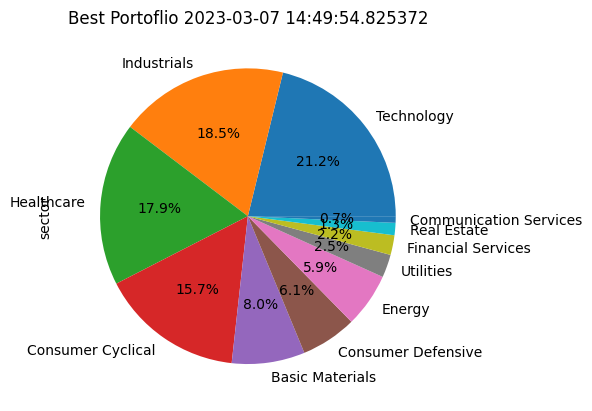

In [97]:
pd.merge(best.reset_index(), meta)['sector'].value_counts().plot.pie(autopct='%1.1f%%', title = f'Best Portoflio {datetime.today()}')

<AxesSubplot:title={'center':'Short Portoflio 2023-03-07 14:49:55.465777'}, ylabel='sector'>

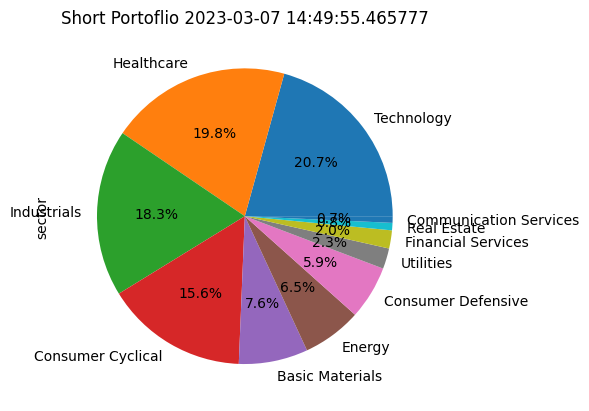

In [98]:
pd.merge(worst.reset_index(), meta)['sector'].value_counts().plot.pie(autopct='%1.1f%%', title = f'Short Portoflio {datetime.today()}')

In [99]:
best, worst = t.get_portfolio(best, worst, cash, long_nticker, short_nticker)

long = 130, short = 30


In [100]:
best

,date,mve,acc,agr,beta,bm,ep,gma,idiovol,lev,...,retvol,saleinv,currat,predict,tradable,shortable,ask,bid,rnk,target
ticker,,,,,,,,,,,,,,,,,,,,,
ACCO,2023-03-06,6.233234,-0.030740,-0.095947,1.577400,1.590232,-0.025912,0.178663,0.056350,3.895783,...,0.032336,1.0,1.498,2.000155,True,True,6.43,5.36,1.0,153
UCTT,2023-03-06,7.231359,-0.003454,-0.031846,2.044939,0.622264,0.028313,0.229584,0.063525,0.717576,...,0.027075,1.0,2.823,1.698725,True,True,36.60,24.37,2.0,26
CAAS,2023-03-06,5.403578,-0.024600,0.013005,0.981239,3.367537,0.115911,0.101870,0.117213,3.978948,...,0.055838,1.0,1.425,1.646077,True,False,8.68,5.76,3.0,113
SBGI,2023-03-06,6.988874,0.280545,-0.614047,1.525964,0.673299,2.387150,0.065055,0.069316,5.246870,...,0.024895,1.0,2.768,1.590701,True,True,15.53,12.46,4.0,63
BAND,2023-03-06,6.017620,-0.015274,-0.127842,1.052270,0.614816,0.044206,0.223692,0.091018,1.484404,...,0.073001,1.0,2.453,1.582530,True,True,15.72,15.70,5.0,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RNA,2023-03-06,7.366824,-0.078957,0.493989,1.012457,0.344472,-0.103683,0.021573,0.101924,0.036186,...,0.043894,1.0,12.001,0.647043,True,True,22.70,18.11,1116.0,0
PAR,2023-03-06,6.910252,-0.030430,-0.037484,2.022563,0.397098,-0.073366,0.100538,0.071035,0.507667,...,0.030715,1.0,3.302,0.644544,True,True,42.94,28.54,1117.0,0
LUNG,2023-03-06,6.093795,-0.066582,-0.176453,1.985743,0.356329,-0.136331,0.169514,0.095923,0.091783,...,0.052032,1.0,9.137,0.643500,True,True,14.23,11.83,1118.0,0


In [101]:
t.make_trade(best, worst)

(0, 0)

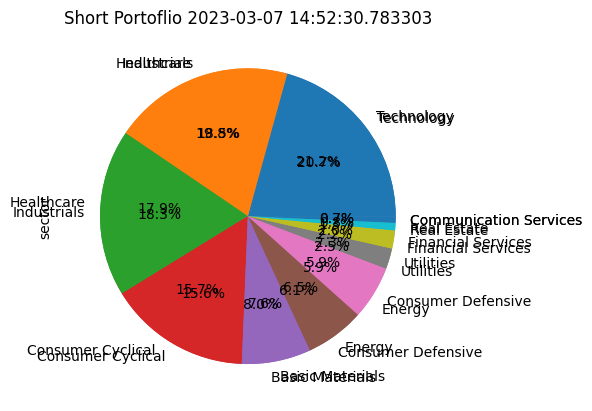

In [107]:
# rice acc
t.save_results(best, worst, acc='rice')
pd.merge(best.reset_index(), meta)['sector'].value_counts().plot.pie(autopct='%1.1f%%', title = f'Best Portoflio {datetime.today()}').figure.savefig(t.folder + 'long.png')
pd.merge(worst.reset_index(), meta)['sector'].value_counts().plot.pie(autopct='%1.1f%%', title = f'Short Portoflio {datetime.today()}').figure.savefig(t.folder + 'short.png')

In [108]:
# trading_client = TradingClient(R_Key, R_Secret_key, paper=True)
# today = datetime.today().strftime("%Y-%m-%d")
# worst['type'] = 'Worst'
# best['type'] = 'Best'

# worst["date"] = today
# best["date"] = today

# try:
#     df2 = pd.read_csv(f"./results_2/trade_data.csv", index_col="ticker")
#     df2 = df2[df2.date != today]
#     df2 = pd.concat((df2, pd.concat((worst, best))))
#     df2.to_csv(f"./results_2/trade_data.csv")
# except:
#     df2 = pd.concat((worst, best))
#     df2.to_csv("./results_2/trade_data.csv")

# account = trading_client.get_account()
# account = dict(account)
# account = pd.DataFrame(pd.Series(account)).T
# account["date"] = today

# try:
#     d = pd.read_csv("./results_2/account.csv")
#     d = d[d.date != today]
#     account = pd.concat((d, account))
#     account.to_csv("./results_2/account.csv")
# except:
#     account.to_csv("./results_2/account.csv")

# positions = trading_client.get_all_positions()
# positions = {x.symbol: x.qty for x in positions}
# positions = pd.DataFrame(pd.Series(positions))
# positions["date"] = today

# try:
#     d = pd.read_csv("./results_2/positions.csv")
#     d = d[d.date != today]
#     positions = pd.concat((d, positions))
#     positions.to_csv("./results_2/positions.csv")
# except:
#     positions.to_csv("./results_2/positions.csv")